In [1]:
%matplotlib inline
import rebound as r
import numpy as np
import matplotlib.pyplot as plt

## Simulated data:

In [2]:
data_N = 30
data_t = np.linspace(0.1,100,data_N)+0.5*np.random.rand(data_N)
data_rv = 0.500883379885605*(np.sin(2.*np.pi*data_t/50.+0.2*np.pi)+0.6*(np.random.rand(data_N)-0.5))

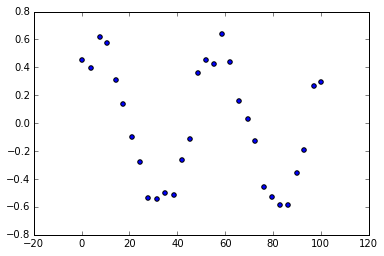

In [3]:
plt.scatter(data_t, data_rv);

## Setting up simulations

In [47]:
def simulation_rv(cart):
    r.reset()
    r.add(m=1.)
    r.add(a=cart[0],e=cart[1],anom=cart[2],omega=cart[3])
    ps = r.particles
    sim_rv = np.zeros(len(data_t))
    for i,t in enumerate(data_t):
        r.integrate(t)
        sim_rv[i] = ps[1].vx
    return sim_rv

def simulation(cart):
    r.reset()
    r.N_megnopp = 4 # 4 variation equations per particle
    r.add(m=1.)
    op = r.Particle(a=cart[0],e=cart[1],anom=cart[2],omega=cart[3])
    
    r.add(op)
    N = r.N
    
    r.init_megno(0.)
    ps = r.particles
    
    
    for k in range(4):
        delta = 1e-6
        cart2 = cart.copy()
        cart2[k] += delta
        mp = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])

        vari = (N*(k+1))+1
        ps[vari].x  = ps[1].x  - mp.x
        ps[vari].y  = ps[1].y  - mp.y
        ps[vari].z  = ps[1].z  - mp.z
        ps[vari].vx = ps[1].vx - mp.vx
        ps[vari].vy = ps[1].vy - mp.vy
        ps[vari].vz = ps[1].vz - mp.vz
     
    sim_rv = 0.
    sim_rvd = np.zeros(4)
    for i,t in enumerate(data_t):
        r.integrate(t)
        sim_rv  += np.square(ps[1].vx-data_rv[i])
        for k in range(4):
            sim_rvd[k] += np.square(ps[1].vx+ps[(k+1)*N+1].vx-data_rv[i])
    err  = np.sqrt(sim_rv)
    errd = np.sqrt(sim_rvd)
    return err, -(errd-err)/delta

## Gradient descent to find minimum

In [55]:
gamma = 0.000005
a = np.array([4.5,0.6,0.,0.]) # initial parameters
sim_rvs = []             # for plotting
errs = []
lastp = 1e200
lasta = a
lastgradient = []

sim_rv0 = simulation_rv(a)

for i in range(600): 
    err, gradient = simulation(a)

    p = err
    if p/lastp < 1.+0.5*np.random.random():
        # Accept new step
        lastp = p
        lasta = a
        sim_rvs.append(sim_rv)
        errs.append(p)
        # New step proposal
        gamma = 1e-1*np.power(10.,-6.*np.random.random())
        a = np.subtract(a,gamma*gradient)
        a[1] = np.clip(a[1],0.,0.9)
        lastgradient = gradient.copy()
    else:
        gamma = 1e-1*np.power(10.,-6.*np.random.random())
        a = np.subtract(lasta,gamma*lastgradient)
        a[1] = np.clip(a[1],0.,0.9)

sim_rv1 = simulation_rv(a)

        

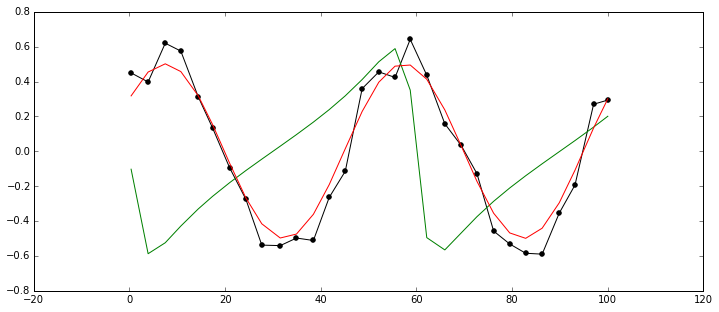

In [61]:
fig = plt.figure(figsize=(12,5))
plt.scatter(data_t, data_rv, color="k");
plt.plot(data_t, data_rv, color="k");
plt.plot(data_t, sim_rv0,color="g");
plt.plot(data_t, sim_rv1,color="r");


Black curve is data, green curve is initial guess, red curve is final "fit".

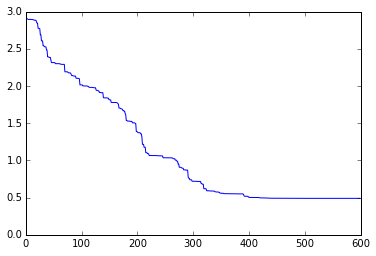

In [59]:
plt.plot(errs);